## Class Observer
 * Class povides us numbers of infected people, death, recoveries etc.

In [75]:
from random import expovariate, uniform, randint

class Observer():
    def __init__(self):
        self.num_infected_persons = 0
        self.num_hospitalized_persons = 0
        self.num_of_deaths = 0
        self.num_of_recoveries = 0
        self.num_of_persons_with_antibodies = 0
        
        self.infected_persons = []
        self.hospitalized_persons = []
        self.deaths = []
        self.recoveries = []
        self.persons_with_antibodies = []
        
    def bake_day_statistics(self):
        self.infected_persons.append(self.num_infected_persons)
        self.hospitalized_persons.append(self.num_hospitalized_persons)
        self.deaths.append(self.num_of_deaths)
        self.recoveries.append(self.num_of_recoveries)
        self.persons_with_antibodies.append(self.num_of_persons_with_antibodies)
    
    def drop_day_statistics(self):
        self.num_infected_persons = 0
        self.num_hospitalized_persons = 0
        self.num_of_deaths = 0
        self.num_of_recoveries = 0
        self.num_of_persons_with_antibodies = 0
             
observer = Observer()
def observer_infections(f):
    observer.num_infected_persons +=1 
    return f

def observer_hospitalized(f):
    observer.num_hospitalized_persons +=1
    return f

def observer_deaths(f):
    observer.num_of_deaths +=1
    return f

def observer_recoveries(f):
    observer.num_of_recoveries +=1
    return f

def observer_antibodies(f):
    observer.num_of_persons_with_antibodies +=1
    return f

# Class Person

In [76]:
class Person:
    MAX_TEMPERATURE_TO_SURVIVE = 44.0
    LOWEST_WATER_PCT_TO_SURVIVE = 0.4
    
    LIFE_THREATENING_TEMPERATURE = 40.0
    LIFE_THREATENING_WATER_PCT = 0.5
    
    def __init__(self, home_position=(0, 0), age=30, weight=70):
        self.virus = None
        self.antibody_types = set()
        self.temperature = 36.6
        self.weight = weight
        self.water = 0.6 * self.weight
        self.age = age
        self.home_position = home_position
        self.position = home_position
        self.state = Healthy(self)
        self.is_hospitalised = False
    
    def __str__(self):
        return(f"virus: {self.virus}, state: {self.state}")
    
    def day_actions(self, health_dept):
        if isinstance(self.state, SymptomaticSick):
            self.state.day_actions(health_dept)
        else:
            self.state.day_actions()

    def night_actions(self):
        self.state.night_actions()

    def interact(self, other):
        self.state.interact(other)
        
    #@observer_infections
    def get_infected(self, virus):
        self.state.get_infected(virus)
    
    #@observer_recoveries
    def get_recovered(self):
        self.set_state(Healthy(self))
    
    def is_close_to(self, other):
        return self.position == other.position
    
    def fightvirus(self):
        if self.virus:
            self.virus.strength -= (1.0 / self.age)
    
    def luck(self):
        return randint(1,100) > 99
        
    def progress_disease(self):
        if self.virus:
            self.virus.cause_symptoms(self)

    def set_state(self, state):
        self.state = state
    
    def is_life_threatening_condition(self):
        return self.temperature >= Person.LIFE_THREATENING_TEMPERATURE or \
            self.water / self.weight <= Person.LIFE_THREATENING_WATER_PCT
    
    def is_life_incompatible_condition(self):        
        return self.temperature >= Person.MAX_TEMPERATURE_TO_SURVIVE or \
            self.water / self.weight <= Person.LOWEST_WATER_PCT_TO_SURVIVE

# Class Infectable

In [77]:
from enum import Enum
from abc import ABC, abstractmethod

class Infectable(ABC):
    def __init__(self, strength=1.0, contag=1.0):
        # contag is for contagiousness so we have less typos
        self.strength = strength
        self.contag = contag

    @abstractmethod
    def cause_symptoms(self, person):
        pass
    
    
class SeasonalFluVirus(Infectable):
    def cause_symptoms(self, person):
        person.temperature += 0.25

    def get_type(self):
        return InfectableType.SeasonalFlu
    
    
class SARSCoV2(Infectable):
    def cause_symptoms(self, person):
        person.temperature += 0.5

    def get_type(self):
        return InfectableType.SARSCoV2


class Cholera(Infectable):
    def cause_symptoms(self, person):
        person.water -= 1.0

    def get_type(self):
        return InfectableType.Cholera
    

class InfectableType(Enum):
    SeasonalFlu = 1
    SARSCoV2 = 2
    Cholera = 3

    
def get_infectable(infectable_type: InfectableType):
    if InfectableType.SeasonalFlu == infectable_type:
        return SeasonalFluVirus(strength=expovariate(10.0), contag=expovariate(10.0))
    
    elif InfectableType.SARSCoV2 == infectable_type:
        return SARSCoV2(strength=expovariate(2.0), contag=expovariate(2.0))
    
    elif InfectableType.Cholera == infectable_type:
        return Cholera(strength=expovariate(2.0), contag=expovariate(2.0))
    
    else:
        raise ValueError()

# Class DepartmentOfHealth

In [78]:
class Hospital:
    def __init__(self, capacity):
        self.capacity = capacity
        self.patients = []
        self.drug_repository = {InfectableType.SARSCoV2 : 10,
                                InfectableType.SeasonalFlu : 10,
                                InfectableType.Cholera : 10}

    def _there_are_drugs(self, disease_type):
        if self.drug_repository[disease_type] > 0:
            self.drug_repository[disease_type] -= 1
            print(self.drug_repository)
            return True
        return False
    
    def _treat_patient(self, patient):
        if patient.virus is not None:
            disease_type = patient.virus.get_type()
            if self._there_are_drugs(disease_type):
                patient.fightvirus()
                        
    def treat_patients(self):
        for patient in self.patients:
                self._treat_patient(patient)
    
    
class DepartmentOfHealth:
    def __init__(self, hospitals):
        self.hospitals = hospitals
        self.num_of_hospitals = len(hospitals)
        
    def monitor_situation(self):
        pass
    
    def issue_policy(self):
        pass
    
    def hospitalize(self, person):
        self.hospitals[randint(0,self.num_of_hospitals-1)].patients.append(person)
        person.is_hospitalised = True
        observer.num_hospitalized_persons+=1

    
class GlobalContext:
    def __init__(self, canvas, persons, health_dept):
        self.canvas = canvas
        self.persons = persons
        self.health_dept = health_dept

# Class State

In [79]:
from abc import ABC, abstractmethod


min_i, max_i = 0, 100
min_j, max_j = 0, 100
    

class State(ABC):
    def __init__(self, person): 
        self.person = person
        
    @abstractmethod
    def day_actions(self): pass

    @abstractmethod
    def night_actions(self): pass

    @abstractmethod
    def interact(self, other): pass

    @abstractmethod
    def get_infected(self, virus): pass


class Healthy(State):
    def day_actions(self):
        self.person.position = (randint(min_j, max_j), randint(min_i, max_i))

    def night_actions(self):
        self.person.position = self.person.home_position

    def interact(self, other: Person): pass

    
    def get_infected(self, virus):
        if virus.get_type() not in self.person.antibody_types:
            self.person.virus = virus
            self.person.set_state(AsymptomaticSick(self.person))
        observer.num_infected_persons+=1


class AsymptomaticSick(State):
    DAYS_SICK_TO_FEEL_BAD = 2
    
    def __init__(self, person):
        super().__init__(person)
        self.days_sick = 0

    def day_actions(self):
        self.person.position = (randint(min_j, max_j), randint(min_i, max_i))

    def night_actions(self):
        self.person.position = self.person.home_position
        if self.days_sick == AsymptomaticSick.DAYS_SICK_TO_FEEL_BAD:
            self.person.set_state(SymptomaticSick(self.person))
        self.days_sick += 1

    def interact(self, other):
        other.get_infected(self.person.virus)

    def get_infected(self, virus): 
        pass


class SymptomaticSick(State):
    def day_actions(self, health_dept):
        self.person.progress_disease()
                    #TODO
        if self.person.is_life_threatening_condition() and not self.person.is_hospitalised and \
                                                            self.person.luck():
            health_dept.hospitalize(self.person)

        if self.person.is_life_incompatible_condition():
            self.person.set_state(Dead(self.person))
            observer.num_of_deaths+=1
            #print('somebody dead')
        
    def night_actions(self):
        if self.person.virus.strength <= 0:
            self.person.get_recovered()
            self.person.antibody_types.add(self.person.virus.get_type())
            self.person.virus = None
            observer.num_of_recoveries+=1
            observer.num_of_persons_with_antibodies+=1

    def interact(self, other):
        other.get_infected(self.person.virus)

    def get_infected(self, virus): pass

    
class Dead(State):
    def day_actions(self): pass

    def night_actions(self): pass

    def interact(self, other): pass

    def get_infected(self, virus): pass


# Simulating

In [80]:
def simulate_day(context):
    persons, health_dept, hospitals = context.persons, context.health_dept, context.health_dept.hospitals

    #ealth_dept.make_policy()
    
    for hospital in hospitals:
        hospital.treat_patients()
    
    for person in persons:
        person.day_actions(health_dept)
    
    for person in persons:
        for other in persons:
            if person is not other and person.is_close_to(other):
                person.interact(other)
                
    for person in persons:
        person.night_actions()
            
    observer.bake_day_statistics()
    observer.drop_day_statistics()

## Context creation

In [81]:
from random import randint


def create_persons(min_j, max_j, min_i, max_i, n_persons):
    min_age, max_age = 1, 90
    min_weight, max_weight = 30, 120
    persons = [
        Person(
            home_position=(randint(min_j, max_j), randint(min_i, max_i)),
            age=randint(min_age, max_age),
            weight=randint(min_weight, max_weight),
        )
        for i in range(n_persons)
    ]
    return persons


def create_department_of_health(hospitals):
    return DepartmentOfHealth(hospitals)


def create_hospitals(n_hospitals):
    hospitals = [
        Hospital(capacity=100)
        for i in range(n_hospitals)
    ]
    return hospitals


def initialize():
    # our little country
    min_i, max_i = 0, 100
    min_j, max_j = 0, 100
    
    # create observer

    
    # our citizen
    n_persons = 1000
    persons = create_persons(min_j, max_j, min_i, max_i, n_persons)
    persons[5].virus = get_infectable(InfectableType.SARSCoV2)
    persons[5].state = AsymptomaticSick(persons[5])
    
    persons[10].virus = get_infectable(InfectableType.SeasonalFlu)
    persons[10].state = AsymptomaticSick(persons[10])
    
    persons[15].virus = get_infectable(InfectableType.Cholera)
    persons[15].state = AsymptomaticSick(persons[15])
    
        
    # our healthcare system
    n_hospitals = 4
    hospitals = create_hospitals(n_hospitals)
    
    health_dept = create_department_of_health(hospitals)
    
    # global context
    context = GlobalContext(
        (min_j, max_j, min_i, max_i),
        persons,
        health_dept
    )
    
    return context

In [82]:
import tqdm
context = initialize()
last_day = None
days_to_simulate = 100
for day in tqdm.tqdm(range(days_to_simulate)):
    last_day = simulate_day(context)

 26%|█████████████████████                                                            | 26/100 [00:18<01:06,  1.11it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 9, <InfectableType.Cholera: 3>: 10}


 27%|█████████████████████▊                                                           | 27/100 [00:19<01:09,  1.05it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 8, <InfectableType.Cholera: 3>: 10}


 28%|██████████████████████▋                                                          | 28/100 [00:20<01:03,  1.14it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 7, <InfectableType.Cholera: 3>: 10}


 29%|███████████████████████▍                                                         | 29/100 [00:21<01:00,  1.18it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 10}


 44%|███████████████████████████████████▋                                             | 44/100 [00:30<00:35,  1.57it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 9}


 45%|████████████████████████████████████▍                                            | 45/100 [00:31<00:35,  1.56it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 8}


 46%|█████████████████████████████████████▎                                           | 46/100 [00:31<00:34,  1.58it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 7}


 47%|██████████████████████████████████████                                           | 47/100 [00:32<00:33,  1.58it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 6}


 48%|██████████████████████████████████████▉                                          | 48/100 [00:33<00:33,  1.56it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 5}


 49%|███████████████████████████████████████▋                                         | 49/100 [00:33<00:33,  1.50it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 4}


 50%|████████████████████████████████████████▌                                        | 50/100 [00:34<00:35,  1.40it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 3}


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:35<00:33,  1.45it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 2}


 52%|██████████████████████████████████████████                                       | 52/100 [00:36<00:33,  1.44it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 1}


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:37<00:39,  1.18it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 0}


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:48<00:17,  1.63it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 9}


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:48<00:18,  1.55it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 8}


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:49<00:19,  1.41it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 7}


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:50<00:17,  1.46it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 6}


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:50<00:16,  1.51it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 5}
{<InfectableType.SARSCoV2: 2>: 9, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 10}


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:51<00:15,  1.56it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 4}
{<InfectableType.SARSCoV2: 2>: 9, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 10}
{<InfectableType.SARSCoV2: 2>: 8, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 10}


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:52<00:14,  1.60it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 3}
{<InfectableType.SARSCoV2: 2>: 8, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 10}
{<InfectableType.SARSCoV2: 2>: 7, <InfectableType.SeasonalFlu: 1>: 10, <InfectableType.Cholera: 3>: 10}


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:52<00:13,  1.58it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 2}


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:53<00:13,  1.56it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 1}


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:54<00:12,  1.57it/s]

{<InfectableType.SARSCoV2: 2>: 10, <InfectableType.SeasonalFlu: 1>: 6, <InfectableType.Cholera: 3>: 0}


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


# Plots

In [83]:
import matplotlib.pyplot as plt
from numpy import cumsum

* Number of infected persons vs. time;

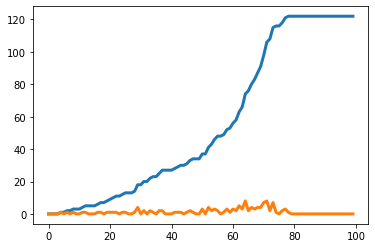

In [84]:
p = plt.plot(cumsum(observer.infected_persons), linewidth=3)
p = plt.plot(observer.infected_persons, linewidth=3)
# cumulative sum

* Number of hospitalized persons vs. time;

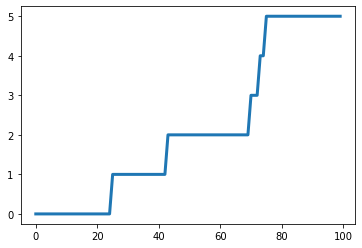

In [85]:
p = plt.plot(cumsum(observer.hospitalized_persons), linewidth=3)
#axes = plt.gca()
#axes.set_xlim([0,days_to_simulate])
#axes.set_ylim([0,max(observer.hospitalized_persons)])
#observer.hospitalized_persons

* Number of deaths vs. time;

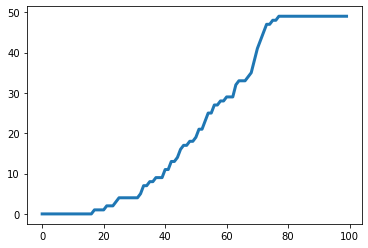

In [86]:
p = plt.plot(cumsum(observer.deaths), linewidth=3)
#axes = plt.gca()
#axes.set_xlim([0,days_to_simulate])
#axes.set_ylim([0,max(observer.deaths)])

* Number of recoveries vs. time;

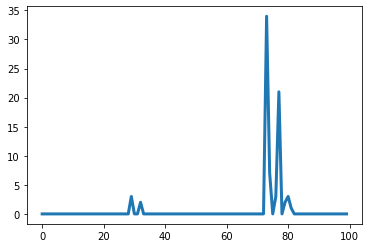

In [87]:
p = plt.plot(observer.recoveries, linewidth=3)
#axes = plt.gca()
#axes.set_xlim([0,days_to_simulate])
#axes.set_ylim([0,max(observer.recoveries)])
#observer.recoveries

* Number of persons with antibodies vs. time.

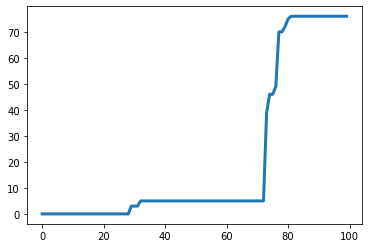

In [88]:
p = plt.plot(cumsum(observer.persons_with_antibodies), linewidth=3)

# Persons with antibodies are the people which have recovered after virus

In [89]:
a = 

SyntaxError: invalid syntax (<ipython-input-89-828ec4a4fd72>, line 1)

### 6 test

In [ ]:
import unittest
class PersonStateToDead((unittest.TestCase)): 
    
    def test_temperature(self):
        #observer = Observer()
        n_hospitals = 1
        hospitals = create_hospitals(n_hospitals)
        health_dept = create_department_of_health(hospitals)
        min_age, max_age = 1, 90
        min_weight, max_weight = 30, 120
        min_i, max_i = 0, 100
        min_j, max_j = 0, 100
        n_persons = 1
        person = Person(
            home_position=(randint(min_j, max_j), randint(min_i, max_i)),
            age=randint(min_age, max_age),
            weight=randint(min_weight, max_weight),
        )
        
        person.virus = get_infectable(InfectableType.Cholera)
        person.state = SymptomaticSick(person)
        person.temperature = 44.0
        
        #for persons in person:
        #    persons.day_actions(health_dept)
        person.day_actions(health_dept)
        result_state = person.state
        self.assertIsInstance(result_state, Dead)
        
       
    def test_water(self):
        #observer = Observer()
        n_hospitals = 1
        hospitals = create_hospitals(n_hospitals)
        health_dept = create_department_of_health(hospitals)
        min_age, max_age = 1, 90
        min_weight, max_weight = 30, 120
        min_i, max_i = 0, 100
        min_j, max_j = 0, 100
        n_persons = 1
        person = Person(
            home_position=(randint(min_j, max_j), randint(min_i, max_i)),
            age=randint(min_age, max_age),
            weight=randint(min_weight, max_weight),
        )
        person.virus = get_infectable(InfectableType.Cholera)
        person.state = SymptomaticSick(person)
        person.water = 0.4 * person.weight
        person.day_actions(health_dept)
        result_state = person.state
        self.assertIsInstance(result_state, Dead)
    

### 5 test A person shall change his health state from infected (with symptoms) to healthy, if the virus has obtained strength below zero.

In [ ]:
import unittest
class PersonStateToHealthy(unittest.TestCase): 
    
    def test_healthy_again(self):
        viruses = ['SARSCoV2','Cholera', 'SeasonalFluVirus']
        for viruss in viruses:
            n_hospitals = 1
            hospitals = create_hospitals(n_hospitals)
            health_dept = create_department_of_health(hospitals)
            min_age, max_age = 1, 90
            min_weight, max_weight = 30, 120
            min_i, max_i = 0, 100
            min_j, max_j = 0, 100
            n_persons = 1
            person = Person(
                home_position=(randint(min_j, max_j), randint(min_i, max_i)),
                age=randint(min_age, max_age),
                weight=randint(min_weight, max_weight),
            )
            if viruss ==  'SARSCoV2':
                person.virus = get_infectable(InfectableType.SARSCoV2)
                person.state = SymptomaticSick(person)
                person.virus.strength = 0
                print(person)
                person.day_actions(health_dept)
                person.night_actions()
                result_state = person.state

                self.assertIsInstance(result_state, Healthy)
            elif viruss ==  'Cholera':
                person.virus = get_infectable(InfectableType.Cholera)
                person.state = SymptomaticSick(person)
                person.virus.strength = 0
                print(person)
                person.day_actions(health_dept)
                person.night_actions()
                result_state = person.state

                self.assertIsInstance(result_state, Healthy)
            else:
                person.virus = get_infectable(InfectableType.SeasonalFlu)
                person.state = SymptomaticSick(person)
                person.virus.strength = 0
                print(person)
                person.day_actions(health_dept)
                person.night_actions()
                result_state = person.state

                self.assertIsInstance(result_state, Healthy)
        

### 1 Each day a person infected (with symptoms) with a seasonal flu or SARS-CoV-2 will demonstrate an increase in temperature, and a person infected (with symptoms) with cholera will demonstrate a water loss.

In [107]:
import unittest
class Temperature_increase((unittest.TestCase)): 
    
    def test_temperature_increase_SARSCoV2(self):
        #observer = Observer()
        n_hospitals = 1
        hospitals = create_hospitals(n_hospitals)
        health_dept = create_department_of_health(hospitals)
        min_age, max_age = 1, 90
        min_weight, max_weight = 30, 120
        min_i, max_i = 0, 100
        min_j, max_j = 0, 100
        n_persons = 1
        person = Person(
            home_position=(randint(min_j, max_j), randint(min_i, max_i)),
            age=randint(min_age, max_age),
            weight=randint(min_weight, max_weight),
        )
        t1 = person.temperature
        person.virus = get_infectable(InfectableType.SARSCoV2)
        person.state = SymptomaticSick(person)
        
        print(t1)
        #for persons in person:
        #    persons.day_actions(health_dept)
        person.day_actions(health_dept)
        person.night_actions()
        SARSCoV2.cause_symptoms(Infectable,person)
        result_state = person.state
        t2 = person.temperature
        print(t2)
        self.assertGreater(t2,t1)
        
    def test_temperature_increase_Flue(self):
        #observer = Observer()
        n_hospitals = 1
        hospitals = create_hospitals(n_hospitals)
        health_dept = create_department_of_health(hospitals)
        min_age, max_age = 1, 90
        min_weight, max_weight = 30, 120
        min_i, max_i = 0, 100
        min_j, max_j = 0, 100
        n_persons = 1
        person = Person(
            home_position=(randint(min_j, max_j), randint(min_i, max_i)),
            age=randint(min_age, max_age),
            weight=randint(min_weight, max_weight),
        )
        t1 = person.temperature
        person.virus = get_infectable(InfectableType.SeasonalFlu)
        person.state = SymptomaticSick(person)
        
        print(t1)
        #for persons in person:
        #    persons.day_actions(health_dept)
        person.day_actions(health_dept)
        person.night_actions()
        SeasonalFluVirus.cause_symptoms(Infectable,person)
        result_state = person.state
        t2 = person.temperature
        print(t2)
        self.assertGreater(t2,t1)
        
       
    def test_water_decrease(self):
        #observer = Observer()
        n_hospitals = 1
        hospitals = create_hospitals(n_hospitals)
        health_dept = create_department_of_health(hospitals)
        min_age, max_age = 1, 90
        min_weight, max_weight = 30, 120
        min_i, max_i = 0, 100
        min_j, max_j = 0, 100
        n_persons = 1
        person = Person(
            home_position=(randint(min_j, max_j), randint(min_i, max_i)),
            age=randint(min_age, max_age),
            weight=randint(min_weight, max_weight),
        )
        w1 = person.water
        person.virus = get_infectable(InfectableType.Cholera)
        person.state = SymptomaticSick(person)
        person.day_actions(health_dept)
        result_state = person.state
        Cholera.cause_symptoms(Infectable,person)
        result_state = person.state
        w2 = person.water
        
        self.assertGreater(w1,w2)
    

In [108]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

......

virus: <__main__.SARSCoV2 object at 0x000001F637D8B820>, state: <__main__.SymptomaticSick object at 0x000001F635167700>
virus: <__main__.Cholera object at 0x000001F6379F7B20>, state: <__main__.SymptomaticSick object at 0x000001F637AC2E20>
virus: <__main__.SeasonalFluVirus object at 0x000001F635167670>, state: <__main__.SymptomaticSick object at 0x000001F637AC2910>
36.6
37.1
36.6
37.6



----------------------------------------------------------------------
Ran 6 tests in 0.012s

OK
